In [1]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

from nbtools import auto_plot_style
from nbtools import normhist
from nbtools import normhist2d
from jupyfun import progressbar

In [47]:
%matplotlib inline
auto_plot_style()

In [3]:
filename = "images.h5"
reco = []
with tb.open_file(filename) as file:
    imgs      = file.root.images
    pos       = file.root.pos
    charges   = file.root.charge
    wires_pos = file.root.wires_pos.read()
    sipms_pos = file.root.sipms_pos.read()
    
    x      = np.unique(sipms_pos[:].T[0]); x.sort()
    x, y   = np.meshgrid(x, x, indexing="ij")
    extent = (sipms_pos.min() - 3, sipms_pos.max() + 3)*2
    ticks  = np.arange(-30, 31, 10)

    for i, (x0, y0) in progressbar(pos, index=True, flush_mod=50):
        img  = imgs[i]
        norm = img.sum()
        xb   = (x*img).sum() / norm
        yb   = (y*img).sum() / norm
        reco.append(pd.DataFrame(dict(x0=x0, y0=y0, xb=xb, yb=yb), index=[0]))
reco = pd.concat(reco, ignore_index=True)

Item 10000 of 10000 | 0.00 s/item | ETA 0.0 min | Ellapsed 0.3 min


In [4]:
reco.loc[:, "dr"] = np.sqrt((reco.xb - reco.x0)**2 + (reco.yb - reco.y0)**2)
reco.loc[:,  "r"] = np.sqrt(reco.x0**2 + reco.y0**2)


In [74]:
rbins  = np.linspace(  0, 32, 81)
xybins = np.linspace(-32, 32, 81)
drbins = np.linspace(  0, 15, 81)

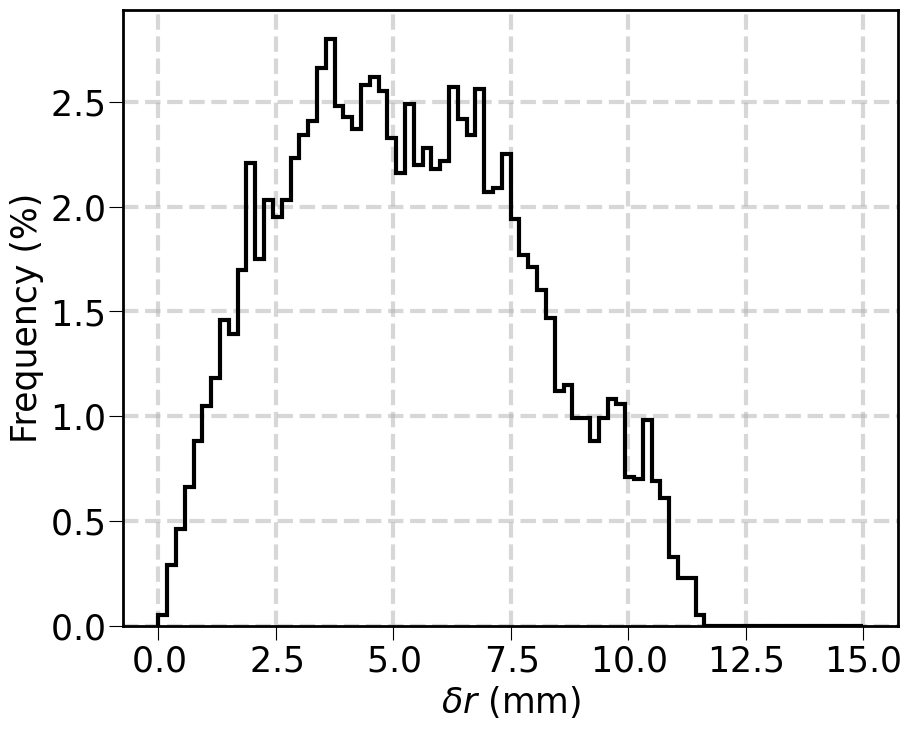

In [29]:
normhist(reco.dr, drbins)
plt.xlabel("$\delta r$ (mm)")
plt.ylabel("Frequency (%)")
plt.grid()

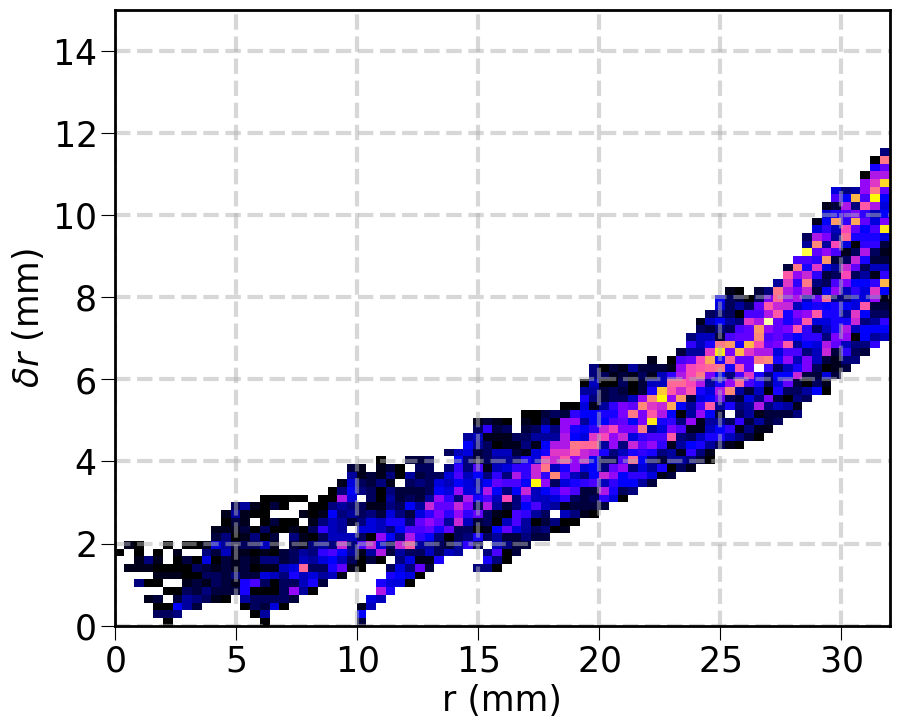

In [30]:
normhist2d(reco.r, reco.dr, (rbins, drbins))
plt.xlabel("r (mm)")
plt.ylabel("$\delta r$ (mm)")
plt.grid()

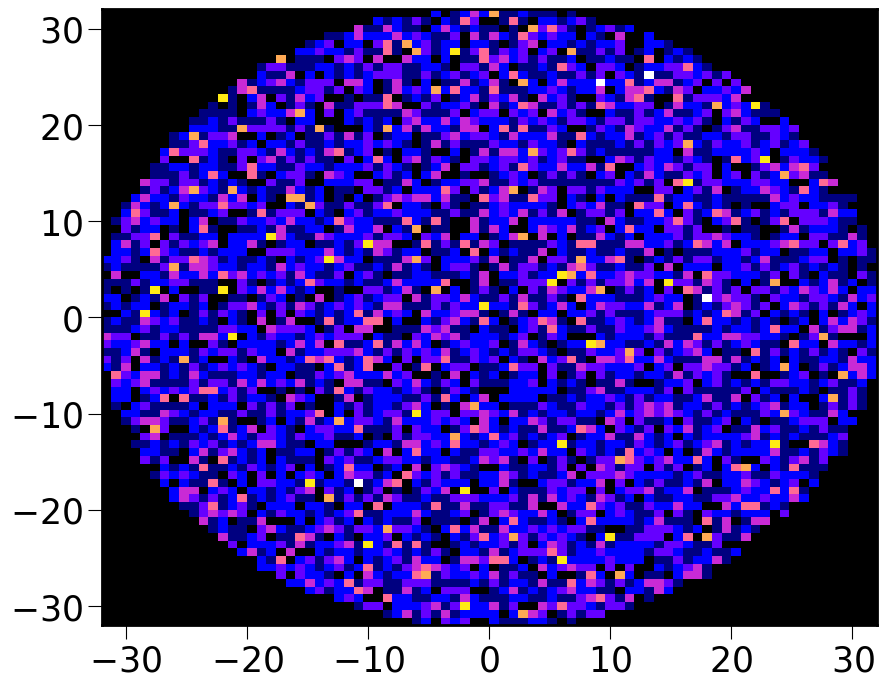

In [31]:
y = plt.hist2d(reco.x0, reco.y0, (xybins, xybins))[0]
evt_per_bin = y[y>0].mean()

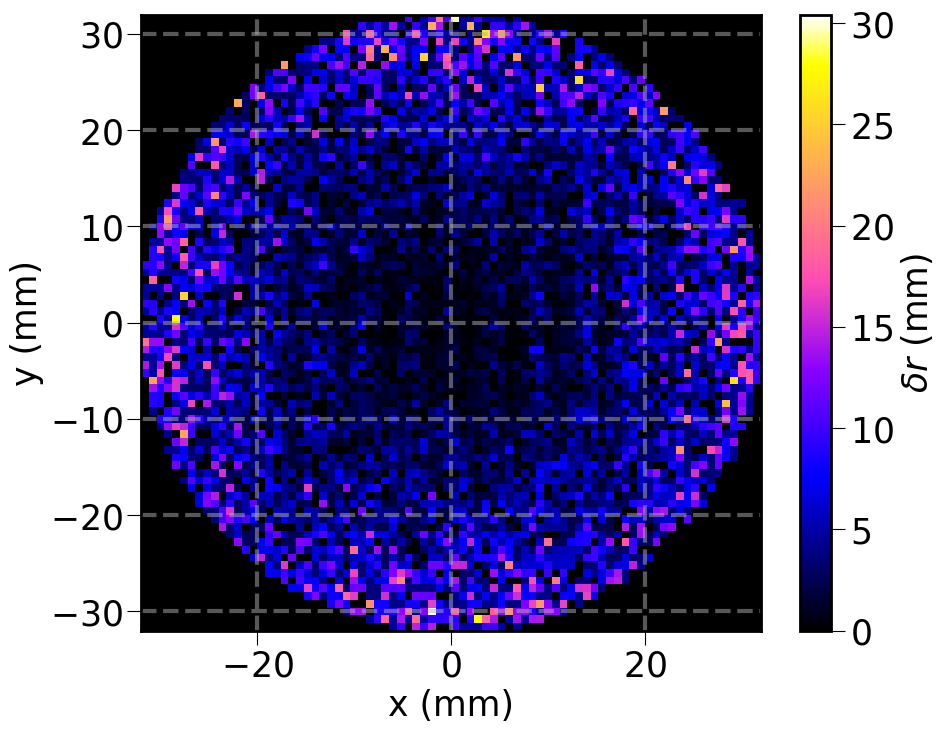

In [32]:
plt.hist2d(reco.x0, reco.y0, (xybins, xybins), weights=reco.dr/evt_per_bin)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar().set_label("$\delta r$ (mm)")
plt.grid()

# NN

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim

In [108]:
class Linear(nn.Module):
    def __init__(self, nx, ny):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1      = nn.Linear(nx*ny, 64, dtype=float)
        self.l2      = nn.Linear(64, 32, dtype=float)
        self.l3      = nn.Linear(32, 2, dtype=float)
        
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x =            self.l3(x)
        return x

In [120]:
filename = "images_100k.h5"
fraction = 0.5
with tb.open_file(filename) as file:
    imgs = file.root.images.read().astype(float)
    pos  = file.root.pos.read().astype(float)

n       = imgs.shape[0]
n_train = int(n*fraction)
n_test  = n - n_train

img_train = torch.tensor(imgs[       :n_train])
img_test  = torch.tensor(imgs[n_train:       ])
pos_train = torch.tensor( pos[       :n_train])
pos_test  = torch.tensor( pos[n_train:       ])

In [128]:
img_train.sum(axis=2).sum(axis=1).mean()/400e3

tensor(0.4907, dtype=torch.float64)

In [121]:
model     = Linear(10, 10)
loss_f    = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [122]:
epochs = 50
batch_size = 32
batch_size = 1000

losses = []
for epoch in progressbar(range(epochs)):
    model.train()  # Set the model to training mode
    permutation = torch.randperm(img_train.size(0))  # Shuffle the dataset

    for i in range(0, img_train.size(0), batch_size):
        # Get the next batch
        indices = permutation[i:i + batch_size]
        imgs, pos = img_train[indices], pos_train[indices]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = loss_f(outputs, pos)

        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())

Item 50 of 50 | 0.15 s/item | ETA 0.0 min | Ellapsed 0.1 min


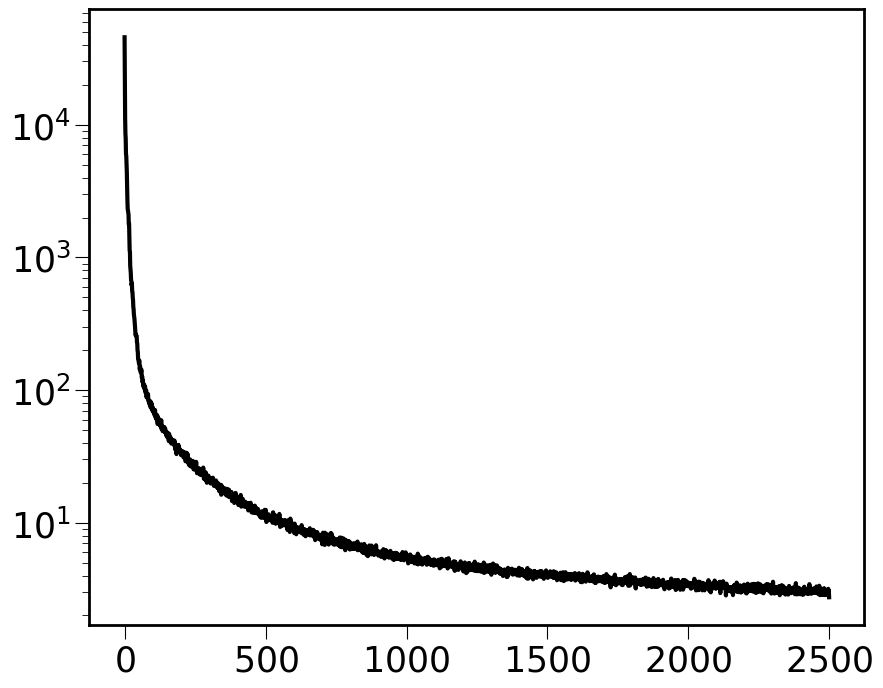

In [123]:
plt.plot(losses)
plt.yscale("log")
plt.show()

In [124]:
model.eval()  # Set the model to evaluation mode
pos_model = model(img_test)
dr = np.sum((pos_model - pos_test).detach().numpy() **2, axis=1)**0.5
r  = np.sum(pos_test.detach().numpy()**2, axis=1)**0.5

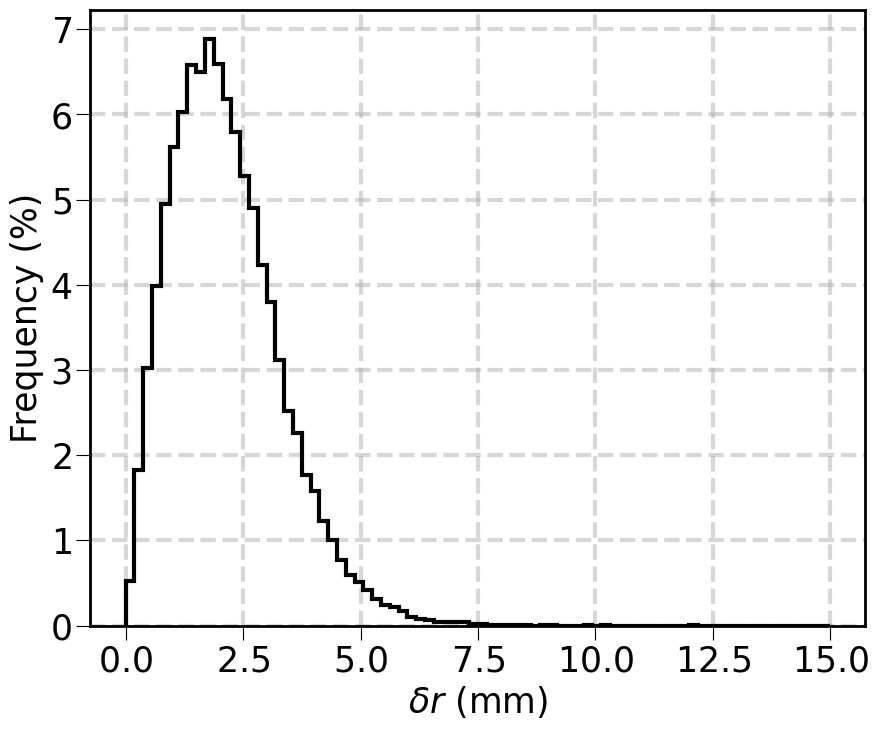

In [125]:
normhist(dr, drbins)
plt.xlabel("$\delta r$ (mm)")
plt.ylabel("Frequency (%)")
plt.grid()
plt.show()

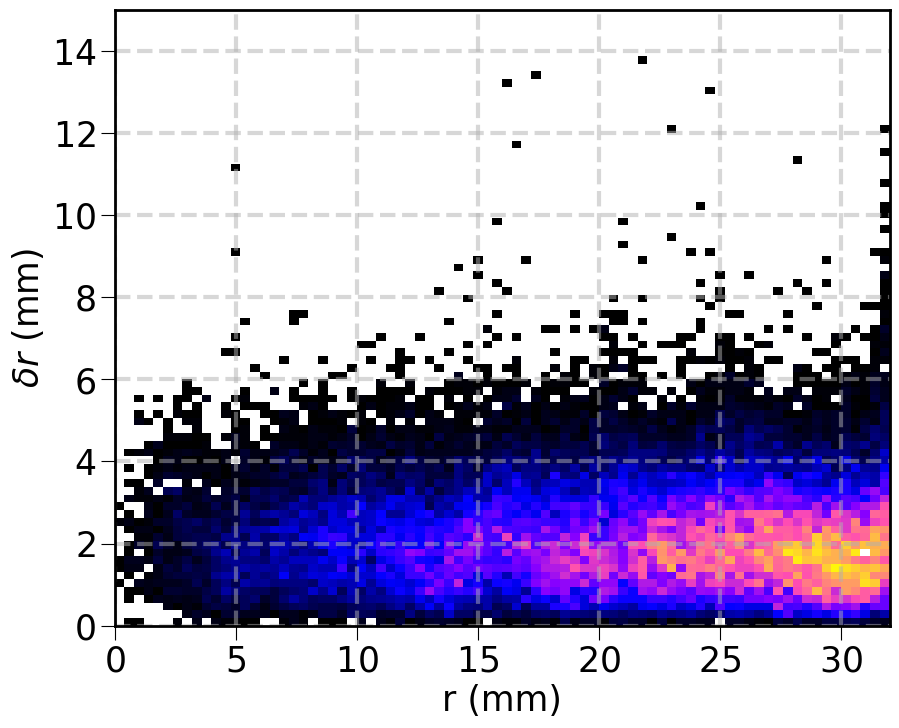

In [126]:
normhist2d(r, dr, (rbins, drbins))
plt.xlabel("r (mm)")
plt.ylabel("$\delta r$ (mm)")
plt.grid()
plt.show()